In [1]:
from RBM_surrogate import *
from Sampling_Quantum import *
from Sampling import *
from functools import partial

In [20]:
N = 2
M = 2
rbm = RBM_surrogate(N,M)
rbm.build_surrogate()
prob_func = partial(prob_Ising_nv, N=N, poly=rbm.poly)  #, log_rho_max=rbm.log_rho_max)

In [21]:
rbm.poly[1+N:] = 0
rbm.poly

array([ 0.00756377, -0.28640102,  0.04526333,  0.        ,  0.        ,
        0.        ,  0.        ])

In [19]:
rbm.log_rho_max

0.33173159832718335

In [44]:
def sampler(s, prob_func, algo='Metropolis_uniform'):
    N=len(s)
    if algo=='Metropolis_uniform':
        s_new = np.random.choice([1,-1],size=N)

        p1 = prob_func(s)
        p2 = prob_func(s_new)

        print(s,s_new,p1,p2)

        accept = min(1.0,p2/p1)
        if np.random.rand()<accept:
            return s_new
        else: return s

In [45]:
def quantum_sampler(N,poly,s,k,angles_u3,angles_2q):
    angles_ry = np.flip(np.pi*(1-s)/2)
    counts = cudaq.sample(Trotter_circuit, N, k, angles_ry, angles_u3, np.reshape(angles_2q,-1), shots_count=1)
    s_new = dict_to_res(counts)

    p1 = prob_Ising_nv(s, N, poly)
    p2 = prob_Ising_nv(s_new, N, poly)

    print(s,s_new,p1,p2)

    accept = min(1.0,p2/p1)
    if np.random.rand()<accept:
          return s_new
    else: return s

In [ ]:
tot_time=12 
time_delta=0.5
gamma=0.42

angles_u3, angles_2q = compute_angles(rbm.poly, N, time_delta, gamma)
k = int(tot_time / time_delta)

s=nrbm.

for i in range(10):
    s=quantum_sampler(N,rbm.poly,s,k,angles_u3,angles_2q)
for _ in range(10):
    s=sampler(s,prob_func)

[ 1 -1] [ 1. -1.] 0.26604213622163836 0.26604213622163836
[ 1. -1.] [-1.  1.] 0.26604213622163836 0.5164525371686794
[-1.  1.] [ 1. -1.] 0.5164525371686794 0.26604213622163836
[ 1. -1.] [-1.  1.] 0.26604213622163836 0.5164525371686794
[-1.  1.] [-1.  1.] 0.5164525371686794 0.5164525371686794
[-1.  1.] [-1.  1.] 0.5164525371686794 0.5164525371686794
[-1.  1.] [1. 1.] 0.5164525371686794 0.2912498120293471
[1. 1.] [ 1. -1.] 0.2912498120293471 0.26604213622163836
[ 1. -1.] [-1.  1.] 0.26604213622163836 0.5164525371686794
[-1.  1.] [-1.  1.] 0.5164525371686794 0.5164525371686794
[-1.  1.] [ 1 -1] 0.5164525371686794 0.26604213622163836
[-1.  1.] [ 1 -1] 0.5164525371686794 0.26604213622163836
[-1.  1.] [1 1] 0.5164525371686794 0.2912498120293471
[-1.  1.] [1 1] 0.5164525371686794 0.2912498120293471
[-1.  1.] [1 1] 0.5164525371686794 0.2912498120293471
[-1.  1.] [1 1] 0.5164525371686794 0.2912498120293471
[-1.  1.] [-1 -1] 0.5164525371686794 0.47175356196142704
[-1.  1.] [ 1 -1] 0.516452537168

In [98]:
def dict_to_res(counts):
  for key, value in counts.items():
    if value == 1: 
        final_config = key

  res = [1.0 if s == '1' else -1.0 for s in final_config]
  
  return np.array(res), -np.flip(res)

In [99]:
@cudaq.kernel
def test(N: int, angles_ry:np.ndarray):  #list[int]
    qreg=cudaq.qvector(N)

    for i in range(N):
        ry(angles_ry[i], qreg[i])

In [100]:
N=3
s = np.flip(np.array([1,1,-1]))
angles_ry = np.pi*(1-s)/2
print(angles_ry)

counts = cudaq.sample(test, N, angles_ry, shots_count=1)
print(counts)
print(np.round(np.array(cudaq.get_state(test, N, angles_ry)),4))
dict_to_res(counts)

[3.14159265 0.         0.        ]
{ 100:1 }

[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


(array([ 1., -1., -1.]), array([ 1.,  1., -1.]))

In [52]:
angles_ry = np.flip(np.pi*(1-s)/2)
counts = cudaq.sample(Trotter_circuit, N, k, angles_ry, angles_u3, np.reshape(angles_2q,-1), shots_count=1)

In [22]:
sample_size = 80000


tm = time.time()
s = rbm.enum(N)
exact_dist = rbm.prob(s)
exact_dist = exact_dist / np.sum(exact_dist)
#plt.plot(1/4 - exact_dist)
print("Exact",  time.time()-tm)

prob_dist = {}
tm = time.time()
prob_dist['uniform'] = Sampling(N=N, prob_func=prob_func, sample_size=sample_size, burn=sample_size//10)
print("Uniform Sampling", time.time()-tm)

tm = time.time()
prob_dist['prop_exact'] = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10, compute_proposal_matrix=True, mode='Exact')
print("Proposal Matrix Exact", time.time()-tm)

tm = time.time()
prob_dist['prop_trot'] = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10, compute_proposal_matrix=True, mode='Trotter')
print("Proposal Matrix Trotter", time.time()-tm)


Exact 0.0009734630584716797
Uniform Sampling 2.8377022743225098
Proposal Matrix Exact 1.0247817039489746
Proposal Matrix Trotter 1.1560277938842773


In [ ]:
sample_size = 10000 #80000
tm = time.time()
prob_dict, _ = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10)
print("Quantum Sampling", time.time()-tm)

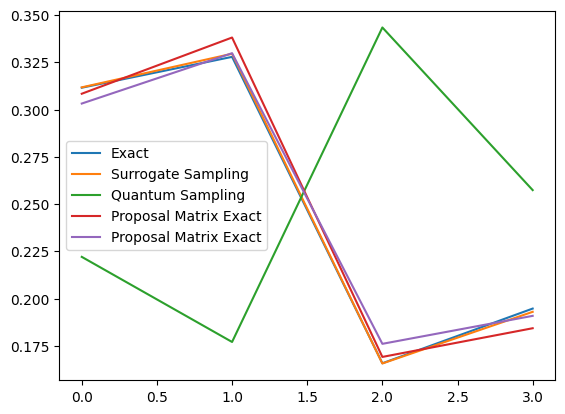

In [23]:
plt.plot(1/2-exact_dist, label='Exact')
plt.plot(1/2-prob_dist['uniform'], label="Surrogate Sampling")
plt.plot(prob_dict.values(), label="Quantum Sampling")
plt.plot(prob_dist['prop_exact'], label="Proposal Matrix Exact")
plt.plot(prob_dist['prop_trot'], label="Proposal Matrix Exact")

plt.legend()
plt.show()

In [ ]:
import cudaq
from cudaq import spin

In [ ]:
from RBM_surrogate import *
#from New_MCMC_Proposal import *
from get_conn import get_conn
#from Sampling import *
from Sampling_Quantum import *

In [ ]:
import os
import numpy as np
#import netket as nk
import scipy as sp
import numpy.linalg as la
import scipy.linalg as spla
import time
import matplotlib.pyplot as plt
import json

In [ ]:
N=8
M=8
D=0
beta=1

In [ ]:
def string_to_spin(str):
    Op = 1
    for i in range(len(str)):
        if str[i]=='X': Op*=spin.x(i)
        elif str[i]=='Y': Op*=spin.y(i)
        elif str[i]=='Z': Op*=spin.z(i)
        elif str[i]=='I': Op*=spin.i(i)
    #print(str, Op)
    return Op

def string_to_ops(str):
    Pauli_Ops = []
    Coeffs = []
    H = 0

    for line in str.strip().split('\n'):
        coeff_str, pauli_op = line.split('] ')
        coeff = complex(coeff_str.strip('['))  
        Coeffs.append(coeff)
        Pauli_Ops.append(pauli_op.strip())
        H += coeff * string_to_spin(pauli_op)

    #print("Pauli_Ops =", Pauli_Ops)
    #print("Coeffs =", Coeffs)

    return H, Pauli_Ops, Coeffs



In [ ]:
with open("ZnO.txt", "r") as file:
    Ham_str = file.read()

Ham, _, _ = string_to_ops(Ham_str)

In [ ]:
print(Ham.get_term_count())

185


In [ ]:
# Adam optimizer hyperparameters
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

In [ ]:
file = "Data/"

In [ ]:
from scipy.sparse import csr_array, coo_matrix
from scipy.sparse.linalg import eigsh

Ham_sp = Ham.to_sparse_matrix()
data, row, col = Ham_sp
Ham_coo = coo_matrix((data, (row, col)), shape=(2**8, 2**8))
Ham_csr = csr_array(Ham_coo)

lmbd, _ = eigsh(Ham_csr, k=1, which='SA')

print("Smallest eigenvalue:", lmbd)

Smallest eigenvalue: [-1852.22917156]


In [ ]:
def plot_log(E_hist, E_smpl_hist):
    #ya, iter = smpl.median_filter(np.real(E_hist))
    ya = np.real(E_hist)
    xa = np.arange(len(ya))
    ci = np.abs(np.array(E_smpl_hist) - ya)
    fig, ax = plt.subplots()
    ax.plot(ya)
    ax.fill_between(xa, (ya-ci), (ya+ci), color='r', alpha=.5)
    ax.set_ylabel("Energy")
    ax.set_xlabel("Epochs")
    plt.hlines(lmbd[0],0,len(xa)-1,color='r',linestyles='dashed')
    plt.show()

In [ ]:
def save_data(X,smpl,g,seed,E,E_smpl,prob_dist,sample_list):
  with open(file+"X_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(X,(1,-1)))
  with open(file+"Poly_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(smpl.poly,(1,-1)))
  with open(file+"E_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, [E])
  with open(file+"E_smpl_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, [E_smpl])
  with open(file+"prob_dist_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(prob_dist,(1,-1)))
  with open(file+"prob_dist_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(sample_list,(1,-1)))

In [ ]:
import tensorflow as tf

2025-04-25 17:59:17.425806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 17:59:17.595868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745603957.654009   15750 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745603957.670397   15750 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 17:59:17.818132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
from functools import partial

sample_size = 20000

seed = 1

E_hist=[]
E_smpl_hist=[]

rbm = RBM_surrogate(N=N,M=M,seed=seed,)
x = tf.Variable(rbm.X)

tm=time.time()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

for epoch in range(40):
  rbm = RBM_surrogate(N,M,X=x.numpy())
  rbm.build_surrogate()

  tm = time.time()
  #prob_func = partial(prob_Ising_nv, N=N, poly=rbm.poly, log_rho_max=rbm.log_rho_max)
  #prob_dist = Sampling(N=N, prob_func=prob_func, sample_size=sample_size, burn=sample_size//10)
  prob_dist = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10)

  print("Sampling Time: ", time.time()-tm)


  E = rbm.Energy_exact(Ham)

  tm = time.time()
  E_smpl = rbm.Energy_sampling(Ham,prob_mat=prob_dist)
  print("Energy: ", time.time()-tm)
  print(epoch, "Energy Time: ", E, "\t +/- \t", np.abs(E_smpl - E))

  tm = time.time()
  #grad_exact = np.real(rbm.grad_exact(Ham))
  grad = np.real(rbm.grad_Sampling(Ham,prob_mat=prob_dist))
  print("Gradient Time: ", time.time()-tm)

  optimizer.apply_gradients([(grad, x)])

  E_hist.append(E)
  E_smpl_hist.append(E_smpl)

print("\n\n\nEnergy: ",E,"\n Time",time.time()-tm, lmbd[0])

plot_log(E_hist, E_smpl_hist)

2025-04-25 17:59:20.454214: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


TypeError: computing_norm_ratio() missing 3 required positional arguments: 'N', 'model_instance_one_body', and 'model_instance_two_body'

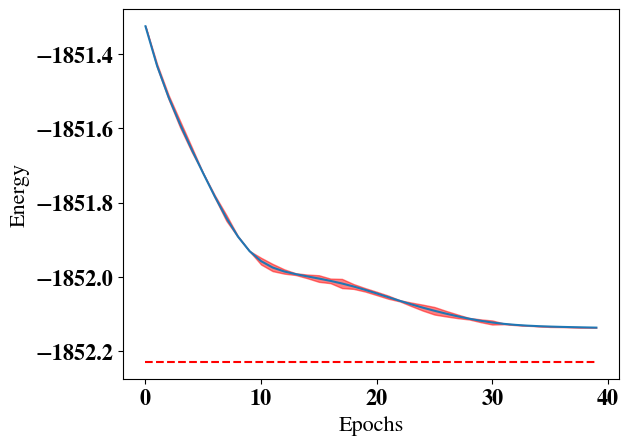

In [ ]:
plot_log(E_hist, E_smpl_hist)

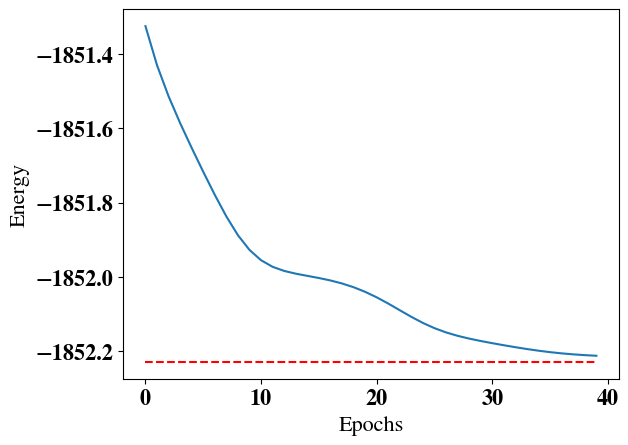

In [ ]:
ya = np.real(E_hist)
xa = np.arange(len(ya))
fig, ax = plt.subplots()
ax.plot(ya)
#ax.fill_between(xa, (ya-ci), (ya+ci), color='r', alpha=.5)
ax.set_ylabel("Energy")
ax.set_xlabel("Epochs")
plt.hlines(lmbd[0],0,len(xa)-1,color='r',linestyles='dashed')